In [1]:
import copy
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

from src.utils import load_all_csv_in_dir

In [2]:
target_dir = "conv_anygrad"
data_dir = os.path.join("..", "PythonAnygrad", "save", target_dir)
data = load_all_csv_in_dir(data_dir)
data = data.dropna(subset=["value"]).sort_values(by="total_iterations")

strategies = np.unique(data["strategy"])
targets = np.unique(data["target"])
num_strategies = len(strategies)
num_targets = len(targets)
data.sort_values(by="total_time", inplace=True)
data

,strategy,rep,round,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
0,"Baseline (round robin, m=256)",0,0,0,Target 1,-217.630600,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
5,"Baseline (round robin, m=8)",0,0,0,Target 6,-218.553558,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
16,"Baseline (round robin, m=3)",0,0,0,Target 17,-218.394279,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
15,"Baseline (round robin, m=3)",0,0,0,Target 16,-218.394279,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
14,"Baseline (round robin, m=3)",0,0,0,Target 15,-218.394279,0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,"Baseline (round robin, m=4096)",0,5,93,Target 18,-151.083411,4096,16384,380928,3659.074745,146.839244,2.906481,0.008962,-0.000129,1.046131e-08,-0.011075
1878,"Baseline (round robin, m=4096)",0,5,93,Target 19,-147.517260,4096,16384,380928,3659.074745,147.268938,2.803208,0.008989,0.000260,-8.636329e-09,0.025102
1869,"Baseline (round robin, m=4096)",0,5,93,Target 10,-151.094149,4096,20480,380928,3659.074745,183.784858,2.595815,0.008974,0.000175,-4.556370e-09,0.017235
1870,"Baseline (round robin, m=4096)",0,5,93,Target 11,-151.826228,4096,20480,380928,3659.074745,183.394049,2.802622,0.008955,0.000044,-1.733568e-10,0.004546


## Imputation

1. We prepend the first non-nan value for each target of each strategy
2. For each timestamp in the data of one strategy we impute the value with the last one measured

In [3]:
def prepend_first_rows(df: pd.DataFrame) -> pd.DataFrame:
    for strategy in np.unique(df["strategy"]):
        for target in np.unique(df["target"]):
            for rep in np.unique(df["rep"]):
                filter_arr = np.logical_and(np.logical_and(df["target"] == target, df["strategy"] == strategy),
                                            df["rep"] == rep)
                first_row = copy.deepcopy(df[filter_arr]).iloc[[0]]
                first_row["total_time"] = 0.0
                first_row["total_iterations"] = 0.0
                first_row["M"] = 0
                first_row = pd.DataFrame(first_row, columns=df.columns)
                df = pd.concat([first_row, df], ignore_index=True)
    return df

data = prepend_first_rows(data)
data


,strategy,rep,round,context_change,target,value,m,M,total_iterations,total_time,time_on_target,t_switch,t1,derivation_1st,derivation_2nd,efficiency
0,"Baseline (round robin, m=8)",0,0,0,Target 9,-218.553558,0,0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1,"Baseline (round robin, m=8)",0,0,0,Target 8,-218.553558,0,0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2,"Baseline (round robin, m=8)",0,0,0,Target 7,-218.553558,0,0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,"Baseline (round robin, m=8)",0,0,0,Target 6,-218.553558,0,0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
4,"Baseline (round robin, m=8)",0,0,0,Target 5,-218.553558,0,0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254255,"Baseline (round robin, m=4096)",0,5,93,Target 18,-151.083411,4096,16384,380928.0,3659.074745,146.839244,2.906481,0.008962,-0.000129,1.046131e-08,-0.011075
254256,"Baseline (round robin, m=4096)",0,5,93,Target 19,-147.517260,4096,16384,380928.0,3659.074745,147.268938,2.803208,0.008989,0.000260,-8.636329e-09,0.025102
254257,"Baseline (round robin, m=4096)",0,5,93,Target 10,-151.094149,4096,20480,380928.0,3659.074745,183.784858,2.595815,0.008974,0.000175,-4.556370e-09,0.017235
254258,"Baseline (round robin, m=4096)",0,5,93,Target 11,-151.826228,4096,20480,380928.0,3659.074745,183.394049,2.802622,0.008955,0.000044,-1.733568e-10,0.004546


In [4]:
np.unique(data["total_time"])

array([   0.        ,   45.35536544,   45.36394642, ..., 3651.00524094,
       3653.42765278, 3659.07474457])

## Raw results
First plot the loss of each target over time

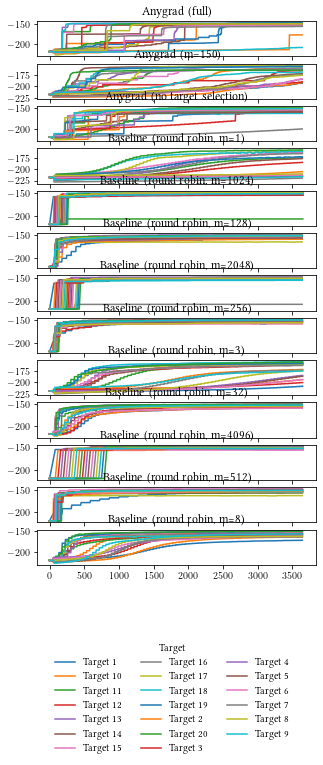

In [5]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_time"], target_data["value"], label=target, marker="")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

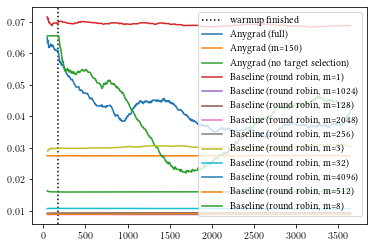

In [14]:
for i, strategy in enumerate(strategies):
    strategy_data = data.groupby("strategy").get_group(strategy)
    ax = axes[i]
    ax.set_title(strategy)
    grouped_strategy_data = strategy_data.groupby("total_time")
    x = (grouped_strategy_data["total_time"].mean()).rolling(window=1).mean()
    y = (grouped_strategy_data.mean().reset_index()["t1"]).rolling(window=1).mean()
    if strategy == "Anygrad (full)":
        remove = grouped_strategy_data.mean()
        warmup = strategy_data.groupby("context_change").mean().reset_index()
        warmup = warmup[warmup["round"] == 3]["total_time"]
        finish_warmup_time = list(warmup)[-1]
        plt.axvline(finish_warmup_time, color="black", ls="dotted", label="warmup finished")
    plt.plot(x, y, label=strategy)
plt.legend()
plt.savefig(os.path.join("save", target_dir + ".pdf"))
plt.show()


## Compute AUC

For convenience averaging, we use a numpy array

In [15]:
def compute_auc(x, y):
    x = np.array(x)
    y = -np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]))
            for i in range(1, len(y), 1)]
    return x[1:], area

num_values = []
for strategy in strategies:
    strategy_arr = []
    for target in targets:
        filter_arr = np.logical_and(data["strategy"] == strategy, data["target"] == target)
        num_values.append(np.sum(filter_arr))
max_num_values = np.max(num_values)

auc_arr = np.empty(shape=(num_strategies, num_targets, 2, max_num_values), dtype=float)
auc_arr.fill(np.nan)
for i, strategy in enumerate(strategies):
    for t, target in enumerate(targets):
        filter_arr = np.logical_and(data["strategy"] == strategy, data["target"] == target)
        target_data = data[filter_arr]
        x = target_data["total_time"]
        y = target_data["value"]
        x, auc = compute_auc(x, y)
        auc_arr[i, t, 0, :len(x)] = x
        auc_arr[i, t, 1, :len(x)] = auc


## AUC

Plot all auc values

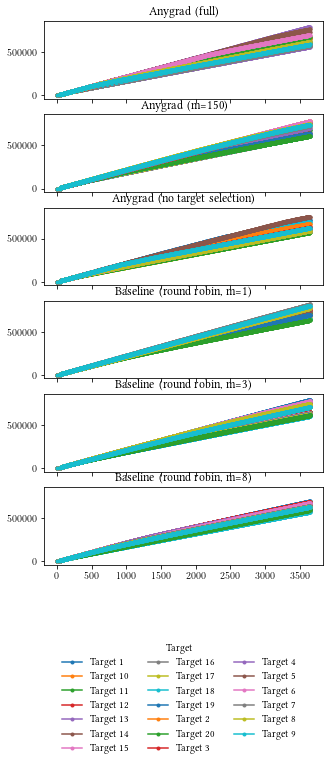

In [8]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", sharey="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for t, target in enumerate(targets):
        x = auc_arr[i, t, 0]
        y = auc_arr[i, t, 1]
        ax.plot(x, y, label=target, marker=".")
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)
<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)
<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)
<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)
<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)
<ipython-input-9-dae00429377c>:6: RuntimeWarning: Mean of empty slice
  y = np.nanmean(auc_arr[i, :, 1], axis=0)


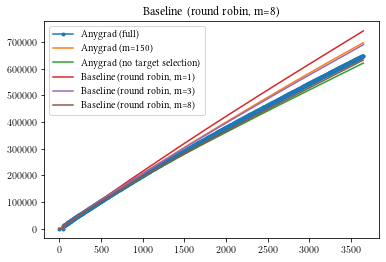

In [9]:
fig, ax = plt.subplots(nrows=1, sharex="all", sharey="all")
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax.set_title(strategy)
    x = auc_arr[i, 0, 0]
    y = np.nanmean(auc_arr[i, :, 1], axis=0)
    if strategy.startswith("Anygrad (full)"):
        ax.plot(x, y, label=strategy, marker=".")
    else:
        ax.plot(x, y, label=strategy, marker="")
handles, labels = ax.get_legend_handles_labels()
ax.set_xscale("linear")
ax.set_yscale("linear")
plt.legend()
plt.show()

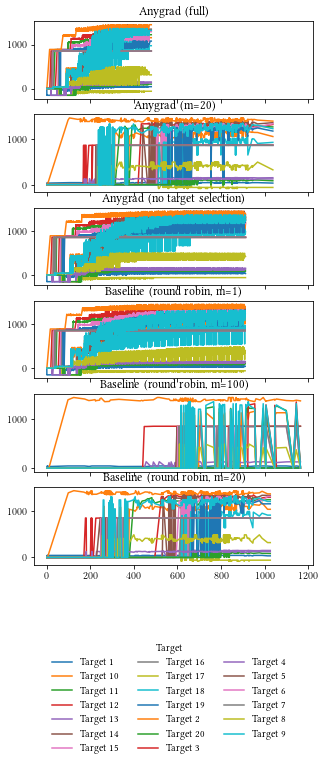

In [17]:
fig, axes = plt.subplots(nrows=num_strategies, sharex="all", figsize=(5,10))
for i, strategy in enumerate(strategies):
    strategy_data = data[data["strategy"] == strategy]
    ax = axes[i]
    ax.set_title(strategy)
    for target in targets:
        target_data = strategy_data[strategy_data["target"] == target]
        ax.plot(target_data["total_time"], target_data["value"], label=target)
handles, labels = axes.flatten()[0].get_legend_handles_labels()
for ax in axes.flatten():
    if ax.get_legend():
        ax.get_legend().remove()
lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
plt.show()

## Average

Compute Average over all targets per strategy

In [18]:
grouped_data = data.groupby(by="strategy")
for strategy in strategies:
    strategy_data = grouped_data.get_group(strategy)
    unique_timestamps = np.unique(strategy_data["total_time"])
    grouped_data_by_timestamp = strategy_data.groupby("total_time")
    for timestamp in unique_timestamps:
        timestamp_data: pd.DataFrame = grouped_data_by_timestamp.get_group(timestamp)
        timestamp_data.mean()



In [9]:
alpha = 0.5

In [ ]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    for target in targets:
        target_data = this_data[this_data["target"] == target]
        axes[0].plot(target_data["total_time"], target_data["efficiency"], label=target, alpha=alpha, marker="o")
        axes[1].plot(target_data["total_time"], target_data["M"], label=target, alpha=alpha, marker="o")
        axes[2].plot(target_data["total_time"], target_data["value"], label=target, alpha=alpha, marker="o")
        axes[0].set_title(strategy)
    axes[0].set_ylabel("Efficiency")
    axes[1].set_ylabel("M")
    axes[2].set_ylabel("Value")
    axes[-1].set_xlabel("Execution time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [ ]:
strategies = np.unique(data["strategy"])
for strategy in strategies:
    fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False)
    this_data = data[data["strategy"] == strategy]
    targets = np.unique(this_data["target"])
    reps = np.unique(this_data["rep"])
    for target in targets:
        for rep in reps:
            target_data = this_data[np.logical_and(this_data["target"] == target, this_data["rep"] == rep)]
            axes[0].plot(target_data["total_time"], target_data["derivation_1st"] / target_data["t1"],
                         label=target, alpha=alpha, marker="x")
            axes[1].plot(target_data["total_time"], target_data["derivation_2nd"],
                         label=target, alpha=alpha, marker="x")
            axes[2].plot(target_data["total_time"], target_data["m"],
                         label=target, alpha=alpha, marker="x")
            axes[0].set_title(strategy)
    axes[0].set_ylabel("1st derivation")
    axes[1].set_ylabel("2nd derivation")
    axes[2].set_ylabel("value")
    axes[-1].set_xlabel("Execution Time")
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    for ax in axes.flatten():
        if ax.get_legend():
            ax.get_legend().remove()
    lgd = plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0., -0.15, 1, 1),
                  frameon=False, ncol=3, title="Target")
    plt.savefig(os.path.join("save", strategy + ".pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [ ]:
def compute_auc_remaining(x, y, offset: float):
    x = np.array(x)
    y = np.array(y)
    x = x[np.invert(np.isnan(y))]
    y = np.nanmin(y) - y[np.invert(np.isnan(y))]
    area = [np.abs(np.trapz(x=x[:i], y=y[:i]) + offset*(x[i-1]-x[0]))
            for i in range(1, len(y), 1)]
    return x[1:], area

def group_df(df: pd.DataFrame):
    df = df.sort_values(by="total_iterations").groupby(by=["strategy", "target"])
    return df

In [ ]:
imputed_data = prepare_data(data)

In [ ]:
imputed_data

In [ ]:
unique_strategies = np.unique(data["strategy"])
unique_targets = np.unique(data["target"])
dataframes = []
for strategy in unique_strategies:
    df = None
    data_for_strategy = imputed_data[imputed_data["strategy"] == strategy].groupby("target")
    for target in unique_targets:
        current_data = data_for_strategy.get_group(target)
        x, y = compute_auc(current_data["total_time"], current_data["value"])
        entries = np.array([[target for _ in x], x, y])
        df = entries.T if df is None else np.vstack([df, entries.T])
    df = pd.DataFrame(df, columns=["target", "total_time", "value"])
    dataframes.append(df)


In [ ]:
for df, strategy in zip(dataframes, unique_strategies):
    grouped_dataframe = df.groupby(by="target")
    total_time = np.array(df["total_time"], dtype=float)
    values = np.array(df["value"], dtype=float)
    x = np.array(np.unique(total_time), dtype=float)
    print(len(x))
    x.sort()
    y = [np.nanmean(values[total_time == ts]) for ts in x]
    plt.plot(x[150:200], y[150:200], label=strategy)
plt.legend()
plt.show()

In [ ]:
min_losses = [np.nanmin(df["value"]) for df in df_per_strategy]
offsets = np.array(min_losses) - np.nanmin(min_losses)
offset = np.nanmax(min_losses)
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc_remaining(x, y, offset=offsets[i])
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Average AUC in $[T_0, T]$")
plt.show()


In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    plt.scatter(x, y, label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"Running mean in $[T_0, T]$")
plt.show()

In [ ]:
for i, df in enumerate(df_per_strategy):
    df = prepend_first_row(df[1:])
    x = df["total_time"]
    y = df["value"]
    x, auc = compute_auc(x, y)
    plt.plot(x, np.array(auc), label=strategies[i])
plt.legend()
plt.xlabel(r"$T [s]$")
plt.ylabel(r"AU Loss Curve in $[T_0, T]$")
plt.show()